# Customer Retention with Cohort Analysis

### import libraries

In [83]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter
import sklearn.preprocessing as preprocessing
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

In [84]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

### Read Dataset

In [85]:
data = pd.read_csv(r'C:\Users\Downloads\data.csv', parse_dates=['created_at'])

In [86]:
df = data.copy()

### Prepare Data

In [87]:
df['total_basket'] = df['basket']+df['discount_cost']


In [88]:
L = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']
df = df.join(pd.concat((getattr(df['created_at'].dt, i).rename(i) for i in L), axis=1))

C:\Users\SnappMarket\AppData\Local\Temp\ipykernel_15680\2301937359.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



In [89]:
df = df[(df['discount_cost'] >= 0) & (df['basket'] > 0)]

In [90]:
df.rename(columns = {'created_at':'order_date'}, inplace = True)

In [91]:
df[['discount_cost', 'basket']] = df[['discount_cost', 'basket']].astype(float)

In [92]:
df.dayofweek.unique()

array([0, 6, 2, 5, 1, 3, 4], dtype=int64)

In [93]:
df['dayofweek'] = df['dayofweek'] + 1

In [94]:
df['order_month'] = df['order_date'].dt.to_period('M')

In [95]:
df.dtypes

order_id                  int64
user_id                   int64
order_date       datetime64[ns]
discount_cost           float64
basket                  float64
total_basket              int64
year                      int64
month                     int64
day                       int64
dayofweek                 int64
dayofyear                 int64
weekofyear                int64
quarter                   int64
order_month           period[M]
dtype: object

In [96]:
print ("Rows     : " , df.shape[0])
print ("Columns  : " , df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nUnique values :  \n", df.nunique())
print ("\nMissing values Total :  ", df.isnull().sum().values.sum())
print ("\nMissing values :  \n", df.isnull().sum())

Rows     :  29057
Columns  :  14

Features : 
 ['order_id', 'user_id', 'order_date', 'discount_cost', 'basket', 'total_basket', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'order_month']

Unique values :  
 order_id         29057
user_id           9985
order_date         215
discount_cost      107
basket             511
total_basket       604
year                 2
month                8
day                 31
dayofweek            7
dayofyear          213
weekofyear          32
quarter              4
order_month         10
dtype: int64

Missing values Total :   0

Missing values :  
 order_id         0
user_id          0
order_date       0
discount_cost    0
basket           0
total_basket     0
year             0
month            0
day              0
dayofweek        0
dayofyear        0
weekofyear       0
quarter          0
order_month      0
dtype: int64


In [97]:
df.shape

(29057, 14)

In [98]:
df.head(10)

,order_id,user_id,order_date,discount_cost,basket,total_basket,year,month,day,dayofweek,dayofyear,weekofyear,quarter,order_month
0,1,1,2021-04-12,10000.0,12000.0,22000,2021,4,12,1,102,15,2,2021-04
1,2,2,2021-05-09,0.0,20000.0,20000,2021,5,9,7,129,18,2,2021-05
2,3,3,2021-05-09,10000.0,14000.0,24000,2021,5,9,7,129,18,2,2021-05
3,4,4,2021-11-10,0.0,15000.0,15000,2021,11,10,3,314,45,4,2021-11
4,5,5,2021-11-10,10000.0,16000.0,26000,2021,11,10,3,314,45,4,2021-11
5,6,6,2022-01-01,0.0,10000.0,10000,2022,1,1,6,1,52,1,2022-01
6,7,7,2022-01-01,0.0,29500.0,29500,2022,1,1,6,1,52,1,2022-01
7,8,8,2022-01-01,10000.0,10000.0,20000,2022,1,1,6,1,52,1,2022-01
8,9,9,2022-01-01,0.0,5000.0,5000,2022,1,1,6,1,52,1,2022-01
9,10,10,2022-01-01,0.0,35000.0,35000,2022,1,1,6,1,52,1,2022-01


### Exploratory Data Analysis

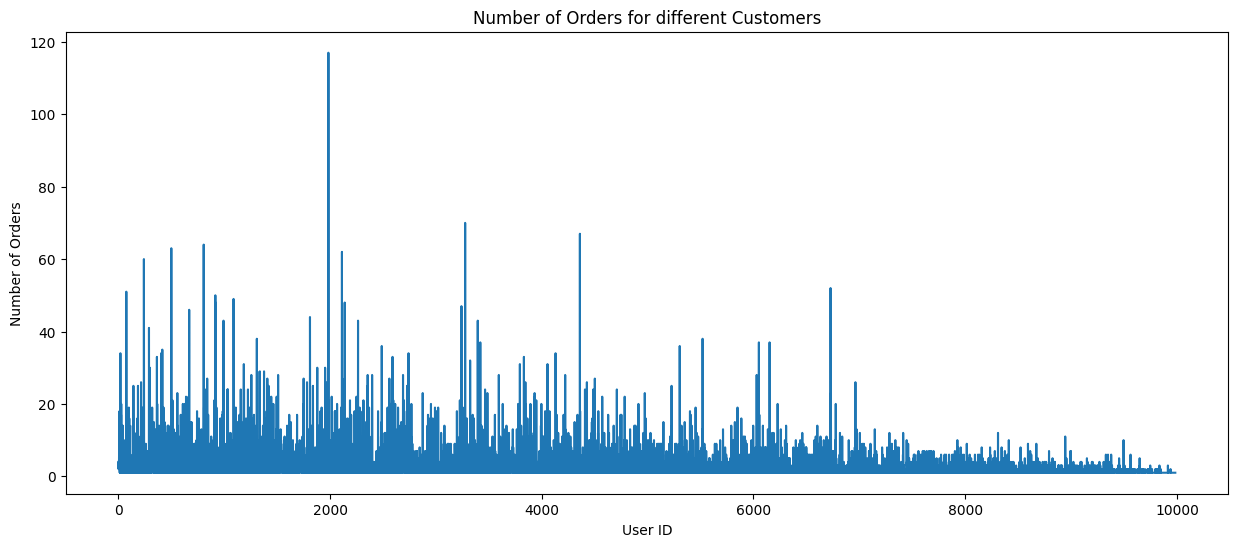

In [99]:
order = df.groupby(by=['user_id'], as_index=False)['order_id'].count()
plt.subplots(figsize=(15,6))
plt.plot(order.user_id, order.order_id)
plt.xlabel('User ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders for different Customers')
plt.show()

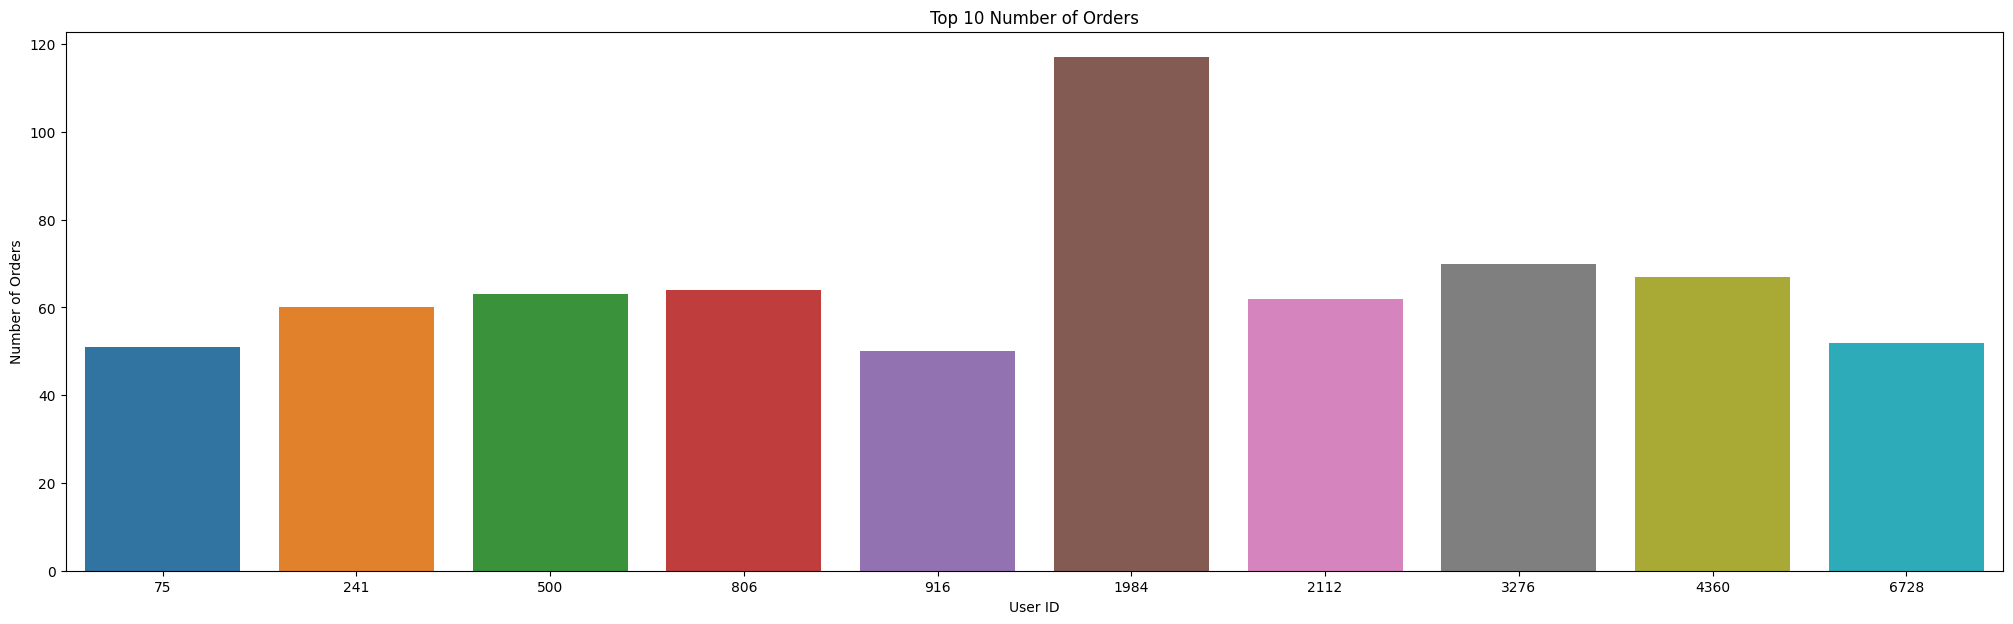

In [100]:
plt.figure(figsize=(25, 7))
sns.barplot(data= order.sort_values(by = ["order_id"], ascending=False)[:10], x="user_id", y =  "order_id")
plt.xlabel('User ID')
plt.ylabel('Number of Orders')
plt.title('Top 10 Number of Orders')
plt.show()

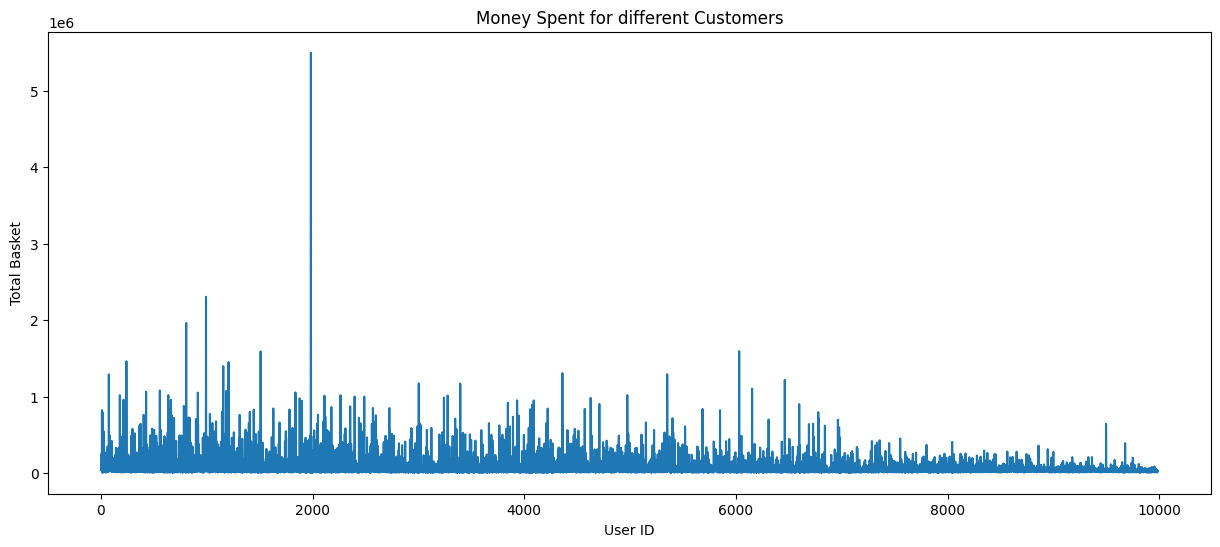

In [101]:
total_cost = df.groupby(by=['user_id'], as_index=False)['total_basket'].sum()
plt.subplots(figsize=(15,6))
plt.plot(total_cost.user_id, total_cost.total_basket)
plt.xlabel('User ID')
plt.ylabel('Total Basket')
plt.title('Money Spent for different Customers')
plt.show()

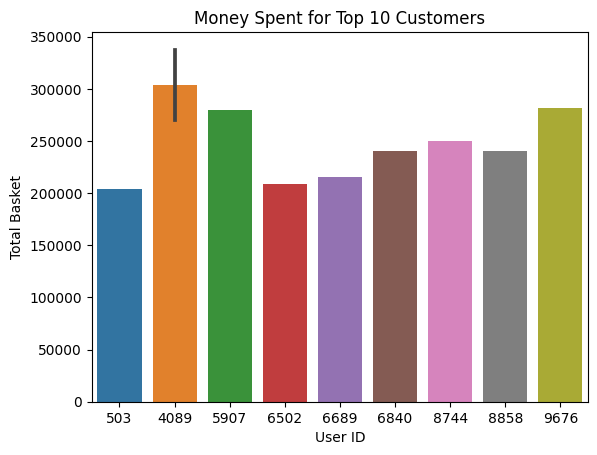

In [102]:
sns.barplot(data=df.sort_values(by = ["total_basket"], ascending=False)[:10], x="user_id", y = "total_basket")
plt.xlabel('User ID')
plt.ylabel('Total Basket')
plt.title('Money Spent for Top 10 Customers')
plt.show()

In [103]:
df.sort_values(by = ["total_basket"], ascending=False)[:10]

,order_id,user_id,order_date,discount_cost,basket,total_basket,year,month,day,dayofweek,dayofyear,weekofyear,quarter,order_month
7533,7534,4089,2022-03-26,0.0,337500.0,337500,2022,3,26,6,85,12,1,2022-03
28060,28061,9676,2022-07-27,0.0,282000.0,282000,2022,7,27,3,208,30,3,2022-07
12864,12865,5907,2022-05-01,0.0,280000.0,280000,2022,5,1,7,121,17,2,2022-05
11664,11665,4089,2022-04-24,0.0,270000.0,270000,2022,4,24,7,114,16,2,2022-04
23633,23634,8744,2022-07-05,0.0,250000.0,250000,2022,7,5,2,186,27,3,2022-07
22571,22572,6840,2022-06-30,0.0,240500.0,240500,2022,6,30,4,181,26,2,2022-06
24061,24062,8858,2022-07-07,0.0,240000.0,240000,2022,7,7,4,188,27,3,2022-07
18908,18909,6689,2022-06-10,0.0,215000.0,215000,2022,6,10,5,161,23,2,2022-06
25496,25497,6502,2022-07-15,6400.0,202000.0,208400,2022,7,15,5,196,28,3,2022-07
1726,1727,503,2022-01-28,0.0,204000.0,204000,2022,1,28,5,28,4,1,2022-01


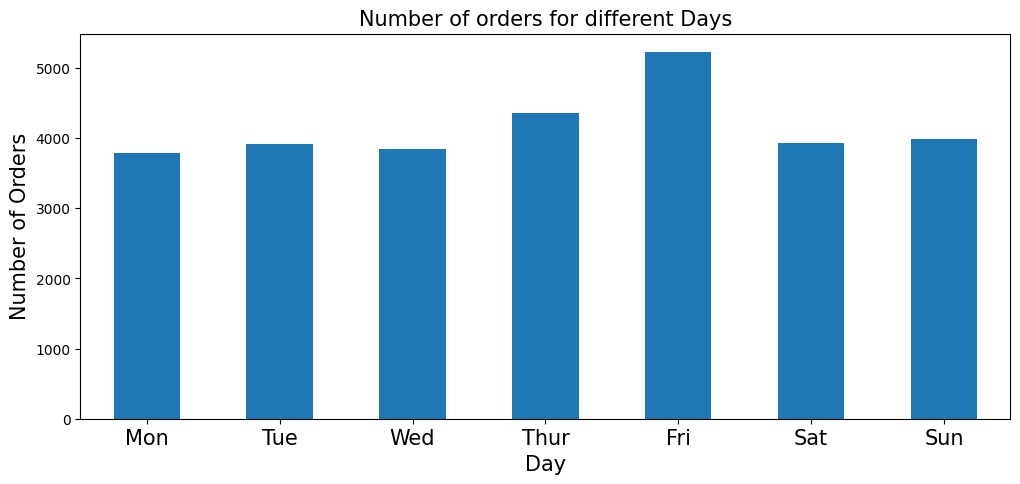

In [104]:
ax = df.groupby('dayofweek')['order_id'].count().sort_index().plot(kind ='bar',figsize=(12,5))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri', 'Sat', 'Sun'), rotation='horizontal', fontsize=15)
plt.show()

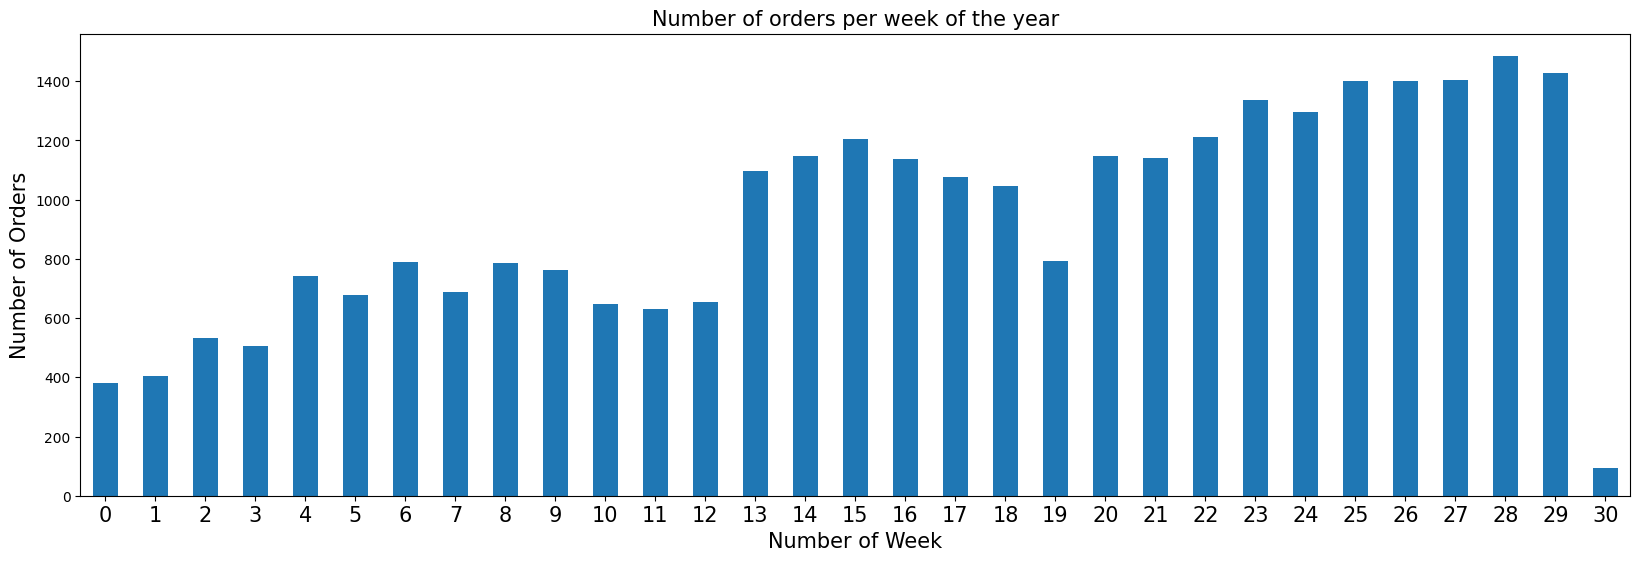

In [105]:
ax = df[df['year']==2022].groupby('weekofyear')['order_id'].count().sort_index().plot(kind = 'bar',figsize=(20,6))
ax.set_xlabel('Number of Week',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders per week of the year',fontsize=15)
ax.set_xticklabels(range(0,31), rotation='horizontal', fontsize=15)
plt.show()

### Cohort Analysis

In [106]:
df['cohort_month'] = df.groupby('user_id')['order_date'].transform('min').dt.to_period('M')

In [107]:
df_cohort = df.groupby(['cohort_month', 'order_month']).agg(num_customers=('user_id', 'nunique')).reset_index(drop=False) 

In [108]:
df_cohort.head()

,cohort_month,order_month,num_customers
0,2021-04,2021-04,1
1,2021-04,2022-03,1
2,2021-04,2022-05,1
3,2021-05,2021-05,2
4,2021-05,2022-03,1


In [109]:
df_cohort['period'] = (df_cohort.order_month - df_cohort.cohort_month).apply(attrgetter('n'))

c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



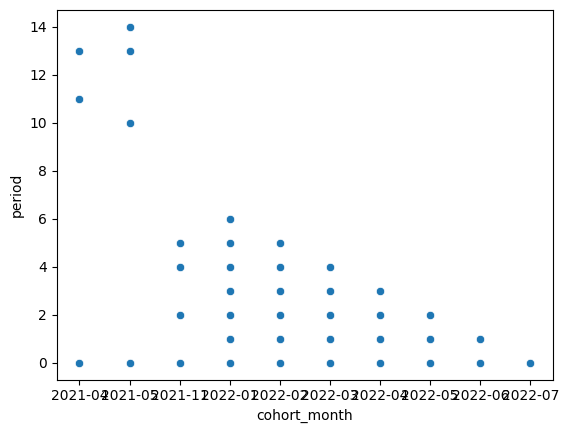

In [110]:
df_cohort['cohort_month'] = df_cohort['cohort_month'].astype(str)
sns.scatterplot(df_cohort['cohort_month'], df_cohort['period'])
plt.show()

In [111]:
df_cohort = df_cohort[~(df_cohort['num_customers'] <= 2)]

In [112]:
cohort_table = df_cohort.pivot_table(index='cohort_month', columns='period', values='num_customers')

In [113]:
cohort_table

period,0,1,2,3,4,5,6
cohort_month,,,,,,,
2022-01,1491.0,457.0,365.0,378.0,316.0,317.0,324.0
2022-02,1539.0,385.0,393.0,362.0,354.0,337.0,NaN
2022-03,1255.0,305.0,274.0,259.0,276.0,NaN,NaN
2022-04,1592.0,421.0,389.0,391.0,NaN,NaN,NaN
2022-05,1192.0,352.0,287.0,NaN,NaN,NaN,NaN
2022-06,1396.0,405.0,NaN,NaN,NaN,NaN,NaN
2022-07,1515.0,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
cohort_size = cohort_table.iloc[:, 0]

In [115]:
retention_matrix = cohort_table.divide(cohort_size, axis=0)

In [116]:
retention_matrix.round(3) * 100

period,0,1,2,3,4,5,6
cohort_month,,,,,,,
2022-01,100.0,30.7,24.5,25.4,21.2,21.3,21.7
2022-02,100.0,25.0,25.5,23.5,23.0,21.9,NaN
2022-03,100.0,24.3,21.8,20.6,22.0,NaN,NaN
2022-04,100.0,26.4,24.4,24.6,NaN,NaN,NaN
2022-05,100.0,29.5,24.1,NaN,NaN,NaN,NaN
2022-06,100.0,29.0,NaN,NaN,NaN,NaN,NaN
2022-07,100.0,NaN,NaN,NaN,NaN,NaN,NaN


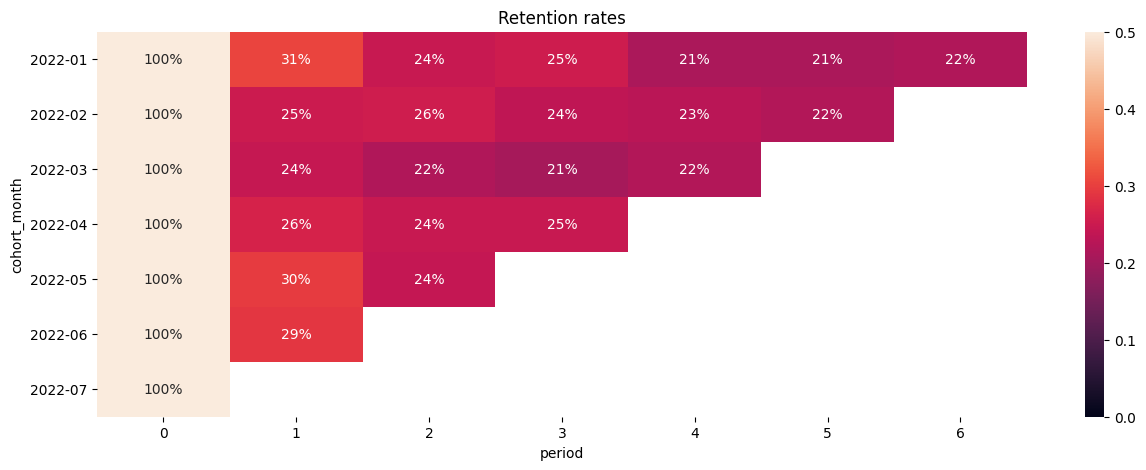

In [117]:
plt.figure(figsize=(15, 5))
plt.title('Retention rates')
sns.heatmap(data=retention_matrix,annot = True,square=False,fmt = '.0%',vmin = 0.0,vmax = 0.5)
plt.show()

In [118]:
df.groupby('order_month')['order_id'].count()

order_month
2021-04       1
2021-05       2
2021-11       2
2022-01    1999
2022-02    2915
2022-03    3132
2022-04    4713
2022-05    4479
2022-06    5419
2022-07    6395
Freq: M, Name: order_id, dtype: int64

In [119]:
retention_matrix.describe()

period,0,1,2,3,4,5,6
count,7.0,6.000000,5.000000,4.000000,3.000000,2.000000,1.000000
mean,1.0,0.274927,0.240722,0.235179,0.220626,0.215791,0.217304
std,0.0,0.026014,0.013653,0.020614,0.009061,0.004500,NaN
min,1.0,0.243028,0.218327,0.206375,0.211938,0.212609,0.217304
25%,1.0,0.253734,0.240772,0.228007,0.215929,0.214200,0.217304
50%,1.0,0.277281,0.244347,0.240410,0.219920,0.215791,0.217304
75%,1.0,0.294005,0.244802,0.247583,0.224970,0.217382,0.217304
max,1.0,0.306506,0.255361,0.253521,0.230019,0.218973,0.217304


In [120]:
performans_date = df["order_date"].max()

### Customer Retention 

In [121]:
df['period'] = (df.order_month - df.cohort_month).apply(attrgetter('n'))

In [122]:
df_orders = df.groupby('period').agg(num_customers=('user_id', 'nunique')).reset_index(drop=False)
df_orders

,period,num_customers
0,0,9985
1,1,2325
2,2,1709
3,3,1390
4,4,947
5,5,655
6,6,324
7,10,1
8,11,1
9,13,2


<function matplotlib.pyplot.show(close=None, block=None)>

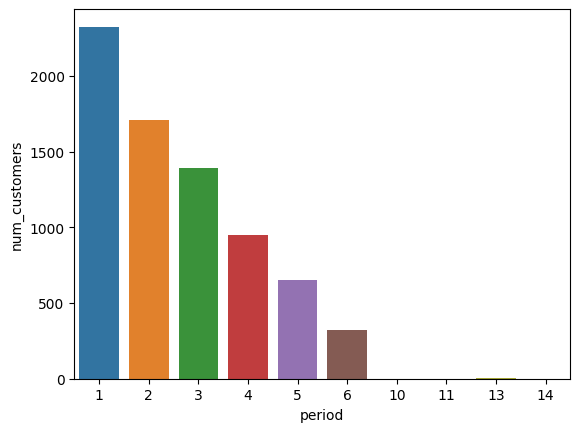

In [123]:
sns.barplot(data= df_orders.sort_values(by = ["period"], ascending=False)[:10], x="period", y =  "num_customers")
plt.show